## Identify TACO (Transfusion-associated circulatory overload) by ICD codes

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from google.cloud import bigquery
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', 100)    # Show all rows



load_dotenv()
query_path = os.environ.get('BASE_QUERY_PATH')
client = bigquery.Client(os.environ.get('BIGQUERY_PROJECT_NAME'))

In [6]:
# ICD codes
with open(f"{query_path}/taco_icd_1d.sql", 'r') as file:
    query_icd = file.read()

results = client.query(query_icd).to_dataframe()
print(results)

/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


      ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  ROW_ID_1 ICD9_CODE_1  \
0     430095       51200   102649       22      7851     12415        7851   
1     546228       76562   109750        4      7852     12986        7852   
2     609382       90911   175746       16      7852     12986        7852   
3     464155       58433   143337       12     78605     13000       78605   
4      18199        1616   177269        8     78605     13000       78605   
...      ...         ...      ...      ...       ...       ...         ...   
5636  404685       45803   127911       14     78609     13003       78609   
5637  617359       92652   127180       13     78609     13003       78609   
5638  533037       73713   107252        9     78609     13003       78609   
5639  414105       47862   199399       20     78609     13003       78609   
5640  417781       48637   148117        9     78609     13003       78609   

                 SHORT_TITLE                       LONG_TITLE  

In [47]:
icd_counts = results[['ICD9_CODE', 'LONG_TITLE']].drop_duplicates().reset_index()
icd_counts['Pt_Count'] = results.drop_duplicates(['SUBJECT_ID', 'ICD9_CODE']).groupby('ICD9_CODE').count().iloc[:,0].values
icd_counts

,index,ICD9_CODE,LONG_TITLE,Pt_Count
0,0,7851,Palpitations,215
1,1,7852,Undiagnosed cardiac murmurs,1926
2,3,78605,Shortness of breath,131
3,13,4280,"Congestive heart failure, unspecified",1586
4,3091,5184,"Acute edema of lung, unspecified",111
5,3223,7823,Edema,169
6,3336,7850,"Tachycardia, unspecified",4
7,3515,27669,Other fluid overload,4
8,3739,51881,Acute respiratory failure,5
9,5597,78609,Other respiratory abnormalities,43


In [48]:
icd_counts['Pt_Count'].sum()

np.int64(4194)

We're lacking temporal data still

## Identify TACO (Transfusion-associated circulatory overload) by lab values
lab values have time recorded 

In [1]:
# Lab values 
with open(f"{query_path}/taco_lab_1d.sql", 'r') as file:
    query_icd = file.read()

results = client.query(query_icd).to_dataframe()
print(results)

NameError: name 'query_path' is not defined

In [15]:
lab_vars = results['LABEL'].values

HR_var = [item for item in lab_vars if re.findall("heart rate", item, re.IGNORECASE)]
HR_var

['Heart rate Alarm - High',
 'Heart Rate',
 'Heart Rate',
 'Heart Rate Alarm - Low']

In [12]:
RR_var = [item for item in lab_vars if re.findall("Resp rate", item, re.IGNORECASE)]
RR_var

['Resp Rate (Spont)', 'Resp Rate (Total)']

In [13]:
SpO2_var = [item for item in lab_vars if re.findall("spo2", item, re.IGNORECASE)]
SpO2_var

['SpO2 Desat Limit', 'SpO2 Alarm [Low]', 'SpO2', 'SpO2 Alarm [High]', 'SpO2-L']

In [14]:
BP_var = [item for item in lab_vars if re.findall("blood pressure", item, re.IGNORECASE)]
BP_var

['Manual Blood Pressure Diastolic Left',
 'Arterial Blood Pressure mean',
 'ART Blood Pressure Alarm - High',
 'ART Blood Pressure Alarm - Low',
 'Arterial Blood Pressure Alarm - Low',
 'Arterial Blood Pressure Alarm - High',
 'ART Blood Pressure Alarm Source',
 'Non Invasive Blood Pressure diastolic',
 'Manual Blood Pressure Systolic Left',
 'Non-Invasive Blood Pressure Alarm - Low',
 'Non Invasive Blood Pressure mean',
 'Arterial Blood Pressure systolic',
 'Non-Invasive Blood Pressure Alarm - High',
 'Manual Blood Pressure Systolic Right',
 'Non Invasive Blood Pressure systolic',
 'Arterial Blood Pressure diastolic',
 'Manual Blood Pressure Diastolic Right']

Vital Variables: 

'Heart Rate' 

'Resp Rate (Spont)', 'Resp Rate (Total)'

'SpO2'

'Manual Blood Pressure Diastolic Left', 'Non Invasive Blood Pressure diastolic', 'Manual Blood Pressure Systolic Left', 'Manual Blood Pressure Systolic Right', 'Non Invasive Blood Pressure systolic', 'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic', 'Manual Blood Pressure Diastolic Right'

In [4]:
# results.to_csv('/home/ch123ck/transfusion-reactions/exploratory_data_analysis/chart_labels_2.csv')

### Clean vitals data before transfusion reaction

In [2]:
## Use sql to query vitals and time
## Get vitals before transfusion
# ICD codes
with open(f"{query_path}/taco_lab_12hr_before.sql", 'r') as file:
    query_icd = file.read()

before_results = client.query(query_icd).to_dataframe()
print(before_results)


/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         SUBJECT_ID           CHARTTIME           starttime  ITEMID  \
0             30659 2146-03-08 15:07:00 2146-03-09 01:39:00  220179   
1             30659 2146-03-08 15:07:00 2146-03-08 22:53:00  220179   
2             70723 2163-11-18 10:40:00 2163-11-18 12:36:00  220179   
3             70723 2163-11-18 10:40:00 2163-11-18 11:59:00  220179   
4             70723 2163-11-18 10:40:00 2163-11-18 22:18:00  220179   
...             ...                 ...                 ...     ...   
1774662       29753 2188-08-27 22:00:00 2188-08-27 22:05:00     211   
1774663       29753 2188-08-27 12:00:00 2188-08-27 22:05:00     211   
1774664       29753 2188-08-27 17:00:00 2188-08-28 01:00:00     211   
1774665       29753 2188-08-28 01:00:00 2188-08-28 01:06:00     211   
1774666       30374 2104-09-03 15:00:00 2104-09-04 01:31:00     211   

                                        LABEL VALUE  VALUENUM VALUEUOM  
0        Non Invasive Blood Pressure systolic    31      31.0     mmHg  
1

In [3]:
# Look at the counts of each vital
before_results['LABEL'].value_counts()

LABEL
Heart Rate                               621341
Arterial Blood Pressure systolic         333521
Arterial Blood Pressure diastolic        333467
Non Invasive Blood Pressure systolic     242911
Non Invasive Blood Pressure diastolic    242725
Manual Blood Pressure Systolic Left         166
Manual Blood Pressure Diastolic Left        162
SpO2                                        137
Manual Blood Pressure Systolic Right        116
Manual Blood Pressure Diastolic Right       105
Resp Rate (Total)                            12
Resp Rate (Spont)                             4
Name: count, dtype: int64

In [4]:
## Unique patient counts 
len(before_results['SUBJECT_ID'].unique())

6348

In [5]:
# Look at a patient's heart rate data 
sub_hr = before_results[before_results['LABEL'] == 'Heart Rate'].sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
sub_hr[sub_hr['SUBJECT_ID'] == 34]

,SUBJECT_ID,CHARTTIME,starttime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM
1695729,34,2191-02-23 05:25:00,2191-02-23 16:19:00,220045,Heart Rate,72,72.0,bpm
1335019,34,2191-02-23 07:34:00,2191-02-23 16:19:00,220045,Heart Rate,44,44.0,bpm
32418,34,2191-02-23 08:00:00,2191-02-23 16:19:00,220045,Heart Rate,43,43.0,bpm
1335018,34,2191-02-23 08:10:00,2191-02-23 16:19:00,220045,Heart Rate,44,44.0,bpm
269244,34,2191-02-23 08:20:00,2191-02-23 16:19:00,220045,Heart Rate,44,44.0,bpm
1001293,34,2191-02-23 09:00:00,2191-02-23 16:19:00,220045,Heart Rate,47,47.0,bpm
980986,34,2191-02-23 10:00:00,2191-02-23 16:19:00,220045,Heart Rate,56,56.0,bpm
506312,34,2191-02-23 11:00:00,2191-02-23 16:19:00,220045,Heart Rate,51,51.0,bpm
1335204,34,2191-02-23 12:00:00,2191-02-23 16:19:00,220045,Heart Rate,52,52.0,bpm
1591880,34,2191-02-23 13:00:00,2191-02-23 16:19:00,220045,Heart Rate,53,53.0,bpm


In [6]:
## Add category to the label 
# Define the conditions and categories
conditions = [
    (before_results['LABEL'] == 'Heart Rate'),
    (before_results['LABEL'].isin(['Arterial Blood Pressure systolic', 
                                   'Non Invasive Blood Pressure systolic', 
                                   'Manual Blood Pressure Systolic Left', 
                                   'Manual Blood Pressure Systolic Right'])),
    (before_results['LABEL'].isin(['Arterial Blood Pressure diastolic', 
                                   'Non Invasive Blood Pressure diastolic', 
                                   'Manual Blood Pressure Diastolic Left', 
                                   'Manual Blood Pressure Diastolic Right'])),
    (before_results['LABEL'] == 'SpO2'),
    (before_results['LABEL'].isin(['Resp Rate (Total)', 'Resp Rate (Spont)']))
]

categories = ['HR', 'BP_SYS', 'BP_DIA', 'SPO2', 'RR']

# Set default to a string value like 'Unknown'
before_results['Category'] = np.select(conditions, categories, default='Unknown')
before_results # This table is useful for Sehyo' review of vital signs

,SUBJECT_ID,CHARTTIME,starttime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,30659,2146-03-08 15:07:00,2146-03-09 01:39:00,220179,Non Invasive Blood Pressure systolic,31,31.0,mmHg,BP_SYS
1,30659,2146-03-08 15:07:00,2146-03-08 22:53:00,220179,Non Invasive Blood Pressure systolic,31,31.0,mmHg,BP_SYS
2,70723,2163-11-18 10:40:00,2163-11-18 12:36:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
3,70723,2163-11-18 10:40:00,2163-11-18 11:59:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
4,70723,2163-11-18 10:40:00,2163-11-18 22:18:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...
1774662,29753,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,HR
1774663,29753,2188-08-27 12:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,HR
1774664,29753,2188-08-27 17:00:00,2188-08-28 01:00:00,211,Heart Rate,80,80.0,BPM,HR
1774665,29753,2188-08-28 01:00:00,2188-08-28 01:06:00,211,Heart Rate,80,80.0,BPM,HR


In [7]:
# Get only the closest record per vital sign to the start date
# Ensure STARTTIME is in datetime format
before_results['starttime'] = pd.to_datetime(before_results['starttime'])

# Sort by SUBJECT_ID, Category, and STARTTIME (latest first)
before_results_sorted = before_results.sort_values(by=['SUBJECT_ID', 'Category', 'starttime'], ascending=[True, True, False])

# Drop duplicates to keep only the latest STARTTIME for each SUBJECT_ID and Category
before_unique = before_results_sorted.drop_duplicates(subset=['SUBJECT_ID', 'Category'], keep='first')

# Reset index for a clean DataFrame
before_unique = before_unique.reset_index(drop=True)

# Display the result
before_unique

,SUBJECT_ID,CHARTTIME,starttime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,34,2191-02-23 14:48:00,2191-02-23 16:19:00,220180,Non Invasive Blood Pressure diastolic,72,72.0,mmHg,BP_DIA
1,34,2191-02-23 07:34:00,2191-02-23 16:19:00,220179,Non Invasive Blood Pressure systolic,135,135.0,mmHg,BP_SYS
2,34,2191-02-23 08:00:00,2191-02-23 16:19:00,220045,Heart Rate,43,43.0,bpm,HR
3,107,2122-05-14 21:08:00,2122-05-14 23:10:00,220180,Non Invasive Blood Pressure diastolic,20,20.0,mmHg,BP_DIA
4,107,2122-05-14 22:04:00,2122-05-14 23:10:00,220179,Non Invasive Blood Pressure systolic,85,85.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...
18954,99982,2156-12-04 14:00:00,2156-12-04 18:23:00,220179,Non Invasive Blood Pressure systolic,98,98.0,mmHg,BP_SYS
18955,99982,2156-12-04 17:00:00,2156-12-04 18:23:00,220045,Heart Rate,93,93.0,bpm,HR
18956,99995,2147-02-08 22:00:00,2147-02-09 00:00:00,220051,Arterial Blood Pressure diastolic,59,59.0,mmHg,BP_DIA
18957,99995,2147-02-08 19:00:00,2147-02-09 00:00:00,220050,Arterial Blood Pressure systolic,146,146.0,mmHg,BP_SYS


In [8]:
# Count the number of vital signs and patients
print(before_unique['Category'].value_counts())
print(f"total patient counts: {len(before_unique['SUBJECT_ID'].unique())}")

Category
HR        6346
BP_DIA    6300
BP_SYS    6300
SPO2         9
RR           4
Name: count, dtype: int64
total patient counts: 6348


### Clean vitals data after transfusion reaction

In [9]:
## Get vitals after transfusion
# ICD codes
with open(f"{query_path}/taco_lab_12hr_after.sql", 'r') as file:
    query_icd = file.read()

after_results = client.query(query_icd).to_dataframe()
print(after_results)


/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         SUBJECT_ID           CHARTTIME             endtime  ITEMID  \
0             15645 2157-04-06 18:05:00 2157-04-06 16:10:00  220179   
1             70723 2163-11-18 10:40:00 2163-11-18 05:30:00  220179   
2             15645 2157-04-06 18:30:00 2157-04-06 17:10:00  220179   
3             96791 2144-06-11 22:36:00 2144-06-11 12:07:00  220179   
4             96791 2144-06-11 22:36:00 2144-06-11 11:15:00  220179   
...             ...                 ...                 ...     ...   
2124544       30374 2104-09-04 10:00:00 2104-09-04 04:31:00     211   
2124545       32725 2193-09-16 18:00:00 2193-09-16 10:05:00     211   
2124546       32725 2193-09-16 14:00:00 2193-09-16 10:05:00     211   
2124547       32725 2193-09-16 11:30:00 2193-09-16 09:00:00     211   
2124548        8498 2144-08-27 05:45:00 2144-08-27 02:46:00     211   

                                        LABEL VALUE  VALUENUM VALUEUOM  
0        Non Invasive Blood Pressure systolic    33      33.0     mmHg  
1

In [10]:
# Look at the counts of each vital
print(f"Vitals counts : {after_results['LABEL'].value_counts()}")

## Unique patient counts 
print(f"Total patient counts: {len(after_results['SUBJECT_ID'].unique())}")

# Look at a patient's heart rate data 
sub_af_hr = after_results[after_results['LABEL'] == 'Heart Rate'].sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
sub_af_hr[after_results['SUBJECT_ID'] == 34]

Vitals counts : LABEL
Heart Rate                               736073
Arterial Blood Pressure systolic         440397
Arterial Blood Pressure diastolic        440320
Non Invasive Blood Pressure systolic     253579
Non Invasive Blood Pressure diastolic    253453
SpO2                                        222
Manual Blood Pressure Systolic Left         155
Manual Blood Pressure Diastolic Left        149
Manual Blood Pressure Systolic Right         80
Manual Blood Pressure Diastolic Right        65
Resp Rate (Total)                            33
Resp Rate (Spont)                            23
Name: count, dtype: int64
Total patient counts: 6457


/tmp/ipykernel_5362/3828629166.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_af_hr[after_results['SUBJECT_ID'] == 34]


,SUBJECT_ID,CHARTTIME,endtime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM
287040,34,2191-02-23 18:00:00,2191-02-23 17:19:00,220045,Heart Rate,55,55.0,bpm
553205,34,2191-02-23 19:00:00,2191-02-23 17:19:00,220045,Heart Rate,59,59.0,bpm
1527406,34,2191-02-23 20:00:00,2191-02-23 17:19:00,220045,Heart Rate,62,62.0,bpm
657478,34,2191-02-23 21:00:00,2191-02-23 17:19:00,220045,Heart Rate,66,66.0,bpm
1794175,34,2191-02-23 22:00:00,2191-02-23 17:19:00,220045,Heart Rate,61,61.0,bpm
1260959,34,2191-02-23 23:00:00,2191-02-23 17:19:00,220045,Heart Rate,54,54.0,bpm
1261156,34,2191-02-24 00:00:00,2191-02-23 17:19:00,220045,Heart Rate,56,56.0,bpm
1011471,34,2191-02-24 01:00:00,2191-02-23 17:19:00,220045,Heart Rate,57,57.0,bpm
479523,34,2191-02-24 02:00:00,2191-02-23 17:19:00,220045,Heart Rate,55,55.0,bpm
1172274,34,2191-02-24 03:00:00,2191-02-23 17:19:00,220045,Heart Rate,56,56.0,bpm


In [11]:
## Add category to the label 
# Define the conditions and categories
conditions_af = [
    (after_results['LABEL'] == 'Heart Rate'),
    (after_results['LABEL'].isin(['Arterial Blood Pressure systolic', 
                                   'Non Invasive Blood Pressure systolic', 
                                   'Manual Blood Pressure Systolic Left', 
                                   'Manual Blood Pressure Systolic Right'])),
    (after_results['LABEL'].isin(['Arterial Blood Pressure diastolic', 
                                   'Non Invasive Blood Pressure diastolic', 
                                   'Manual Blood Pressure Diastolic Left', 
                                   'Manual Blood Pressure Diastolic Right'])),
    (after_results['LABEL'] == 'SpO2'),
    (after_results['LABEL'].isin(['Resp Rate (Total)', 'Resp Rate (Spont)']))
]

categories_af = ['HR', 'BP_SYS', 'BP_DIA', 'SPO2', 'RR']

# Set default to a string value like 'Unknown'
after_results['Category'] = np.select(conditions_af, categories_af, default='Unknown')
after_results # This table is useful for Sehyo' review of vital signs

,SUBJECT_ID,CHARTTIME,endtime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,15645,2157-04-06 18:05:00,2157-04-06 16:10:00,220179,Non Invasive Blood Pressure systolic,33,33.0,mmHg,BP_SYS
1,70723,2163-11-18 10:40:00,2163-11-18 05:30:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
2,15645,2157-04-06 18:30:00,2157-04-06 17:10:00,220179,Non Invasive Blood Pressure systolic,36,36.0,mmHg,BP_SYS
3,96791,2144-06-11 22:36:00,2144-06-11 12:07:00,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS
4,96791,2144-06-11 22:36:00,2144-06-11 11:15:00,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...
2124544,30374,2104-09-04 10:00:00,2104-09-04 04:31:00,211,Heart Rate,112,112.0,BPM,HR
2124545,32725,2193-09-16 18:00:00,2193-09-16 10:05:00,211,Heart Rate,89,89.0,BPM,HR
2124546,32725,2193-09-16 14:00:00,2193-09-16 10:05:00,211,Heart Rate,89,89.0,BPM,HR
2124547,32725,2193-09-16 11:30:00,2193-09-16 09:00:00,211,Heart Rate,101,101.0,BPM,HR


### Examine before vs after transfusion vital signs 

In [13]:
# Perform a left join on SUBJECT_ID and Category
merged_results = after_results.merge(
    before_unique, 
    on=['SUBJECT_ID', 'Category'], 
    how='left', 
    suffixes=('_after', '_before')  # Add suffixes to distinguish overlapping columns
)

# Display the merged DataFrame
merged_results

,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before
0,15645,2157-04-06 18:05:00,2157-04-06 16:10:00,220179,Non Invasive Blood Pressure systolic,33,33.0,mmHg,BP_SYS,2157-04-06 17:49:00,2157-04-06 17:49:00,220179,Non Invasive Blood Pressure systolic,36,36.0,mmHg
1,70723,2163-11-18 10:40:00,2163-11-18 05:30:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS,2163-11-18 22:00:00,2163-11-19 07:25:00,220050,Arterial Blood Pressure systolic,151,151.0,mmHg
2,15645,2157-04-06 18:30:00,2157-04-06 17:10:00,220179,Non Invasive Blood Pressure systolic,36,36.0,mmHg,BP_SYS,2157-04-06 17:49:00,2157-04-06 17:49:00,220179,Non Invasive Blood Pressure systolic,36,36.0,mmHg
3,96791,2144-06-11 22:36:00,2144-06-11 12:07:00,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS,2144-06-11 08:11:00,2144-06-11 16:22:00,220050,Arterial Blood Pressure systolic,154,154.0,mmHg
4,96791,2144-06-11 22:36:00,2144-06-11 11:15:00,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS,2144-06-11 08:11:00,2144-06-11 16:22:00,220050,Arterial Blood Pressure systolic,154,154.0,mmHg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124544,30374,2104-09-04 10:00:00,2104-09-04 04:31:00,211,Heart Rate,112,112.0,BPM,HR,2104-09-03 14:00:00,2104-09-04 01:31:00,211,Heart Rate,94,94.0,BPM
2124545,32725,2193-09-16 18:00:00,2193-09-16 10:05:00,211,Heart Rate,89,89.0,BPM,HR,2193-09-21 07:00:00,2193-09-21 17:26:00,220045,Heart Rate,98,98.0,bpm
2124546,32725,2193-09-16 14:00:00,2193-09-16 10:05:00,211,Heart Rate,89,89.0,BPM,HR,2193-09-21 07:00:00,2193-09-21 17:26:00,220045,Heart Rate,98,98.0,bpm
2124547,32725,2193-09-16 11:30:00,2193-09-16 09:00:00,211,Heart Rate,101,101.0,BPM,HR,2193-09-21 07:00:00,2193-09-21 17:26:00,220045,Heart Rate,98,98.0,bpm


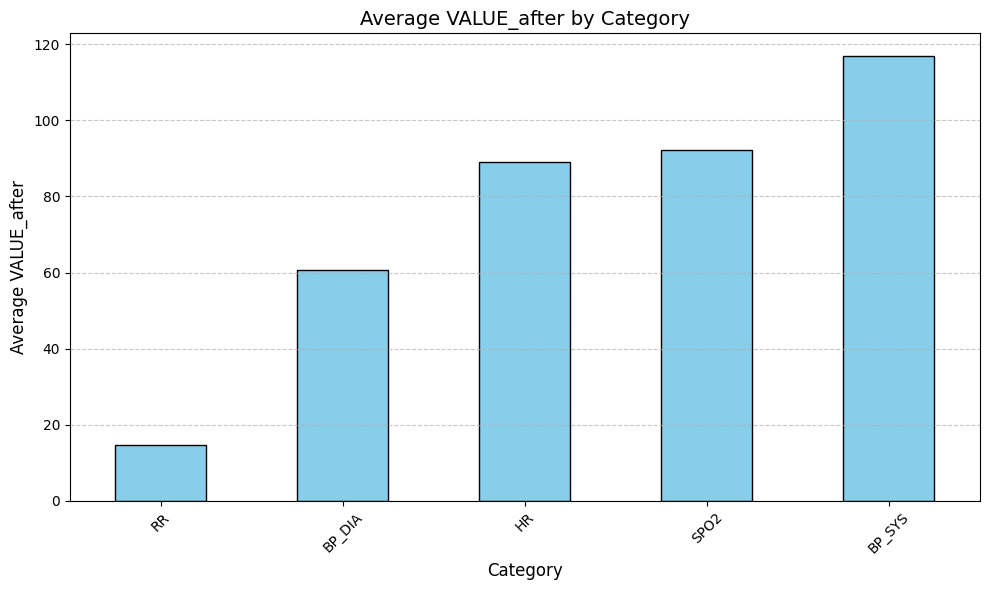

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure VALUE_after is numeric
merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')

# Group by Category and calculate the mean (or any other aggregate like sum, median, etc.)
category_means = merged_results.groupby('Category')['VALUE_after'].mean()

# Sort values for better visualization (optional)
category_means = category_means.sort_values()

# Plot a bar chart
plt.figure(figsize=(10, 6))
category_means.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Average VALUE_after by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average VALUE_after', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


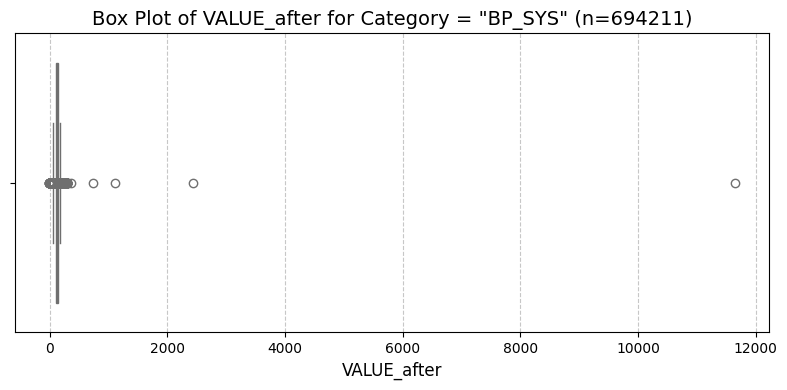

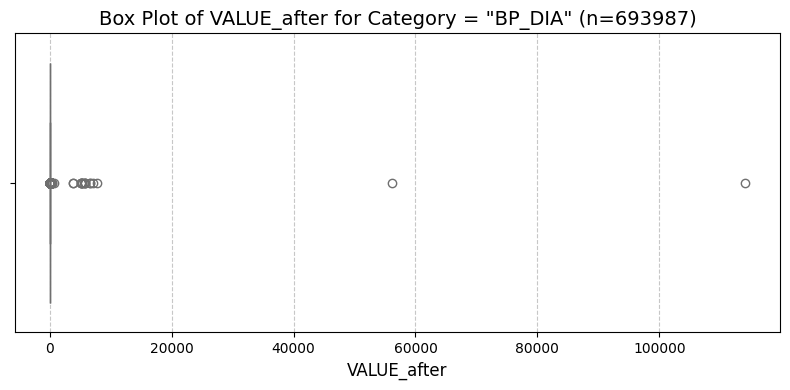

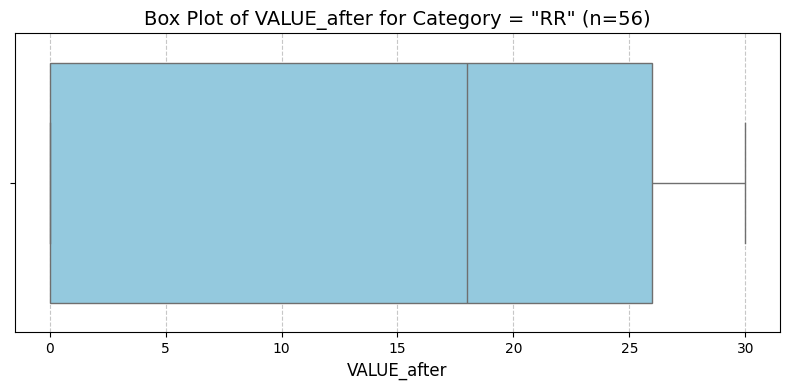

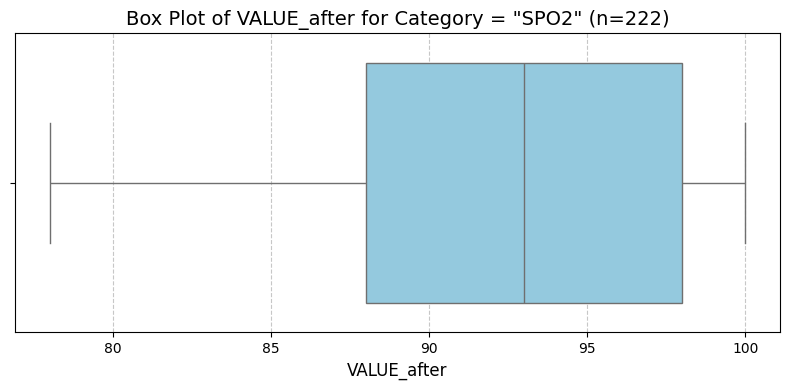

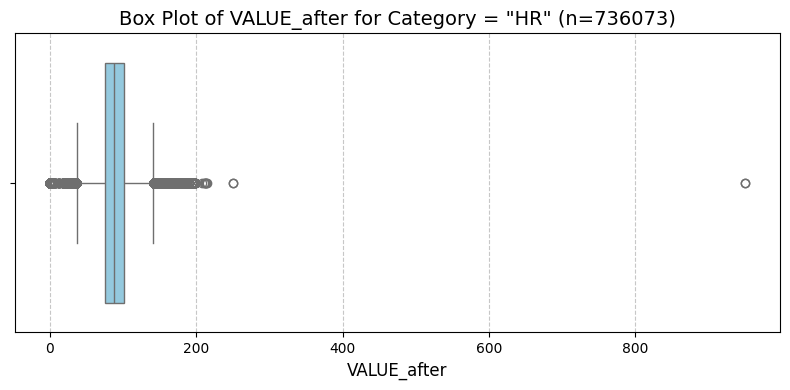

In [26]:
# Plot each vital Category after transfusion 

# Ensure VALUE_after is numeric
merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')

# Get the unique categories
categories = merged_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = merged_results[merged_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



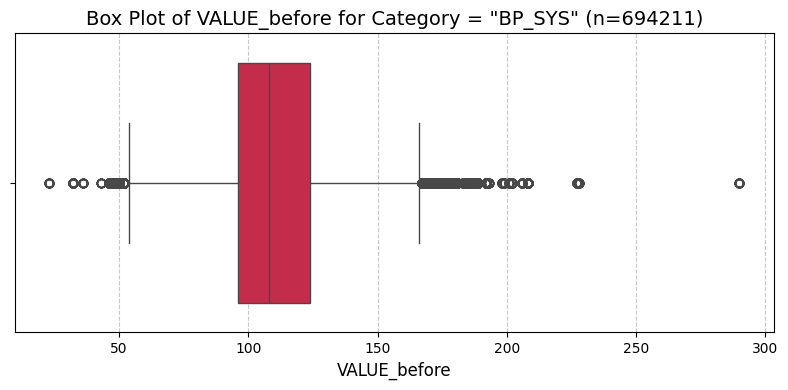

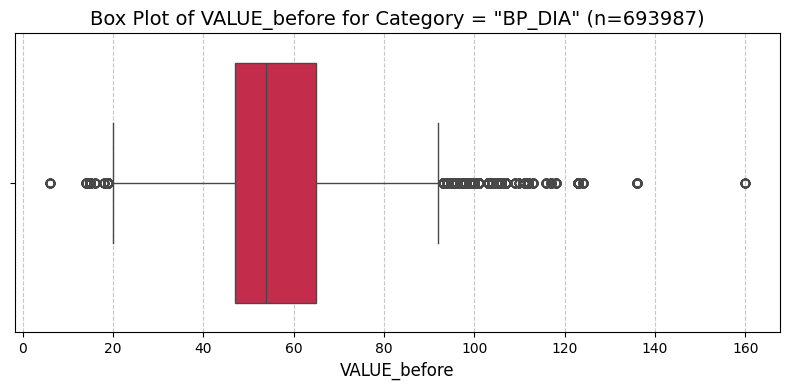

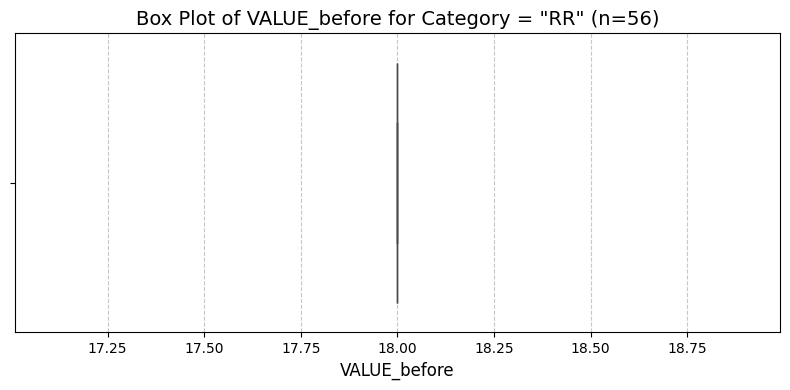

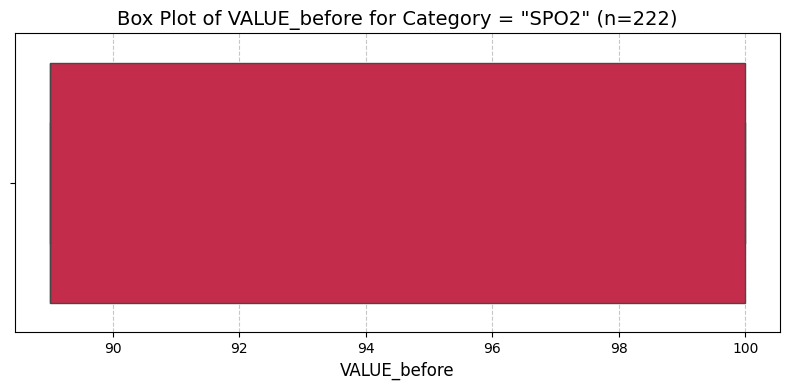

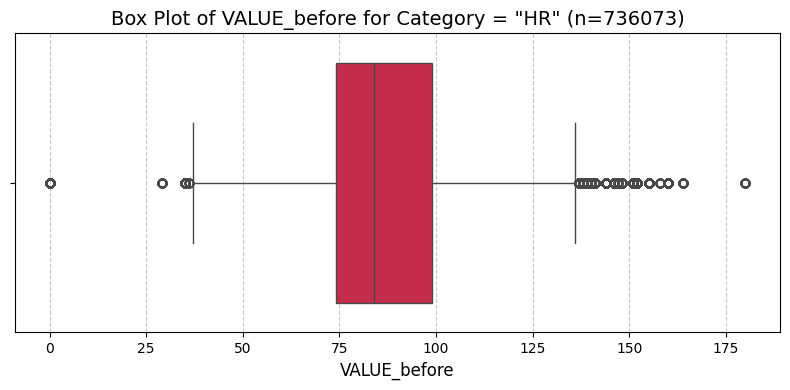

In [25]:
# Plot each vital Category before transfusion 

# Ensure VALUE_before is numeric
merged_results['VALUE_before'] = pd.to_numeric(merged_results['VALUE_before'], errors='coerce')

# Get the unique categories
categories = merged_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = merged_results[merged_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_before',
        orient='h',  # Horizontal orientation
        color='crimson'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_before for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_before', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [28]:
# Want to remove VALUE_AFTER when 
## BP_SYS >= 300
## BP_DIA >= 200
## HR >= 300

# Remove rows based on the specified conditions
filtered_results = merged_results[
    ~(
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_after'] >= 300)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_after'] >= 200)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_after'] >= 300))
    )
]

# Display the filtered DataFrame
filtered_results


,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before
0,15645,2157-04-06 18:05:00,2157-04-06 16:10:00,220179,Non Invasive Blood Pressure systolic,33.0,33.0,mmHg,BP_SYS,2157-04-06 17:49:00,2157-04-06 17:49:00,220179,Non Invasive Blood Pressure systolic,36.0,36.0,mmHg
1,70723,2163-11-18 10:40:00,2163-11-18 05:30:00,220179,Non Invasive Blood Pressure systolic,34.0,34.0,mmHg,BP_SYS,2163-11-18 22:00:00,2163-11-19 07:25:00,220050,Arterial Blood Pressure systolic,151.0,151.0,mmHg
2,15645,2157-04-06 18:30:00,2157-04-06 17:10:00,220179,Non Invasive Blood Pressure systolic,36.0,36.0,mmHg,BP_SYS,2157-04-06 17:49:00,2157-04-06 17:49:00,220179,Non Invasive Blood Pressure systolic,36.0,36.0,mmHg
3,96791,2144-06-11 22:36:00,2144-06-11 12:07:00,220179,Non Invasive Blood Pressure systolic,37.0,37.0,mmHg,BP_SYS,2144-06-11 08:11:00,2144-06-11 16:22:00,220050,Arterial Blood Pressure systolic,154.0,154.0,mmHg
4,96791,2144-06-11 22:36:00,2144-06-11 11:15:00,220179,Non Invasive Blood Pressure systolic,37.0,37.0,mmHg,BP_SYS,2144-06-11 08:11:00,2144-06-11 16:22:00,220050,Arterial Blood Pressure systolic,154.0,154.0,mmHg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124544,30374,2104-09-04 10:00:00,2104-09-04 04:31:00,211,Heart Rate,112.0,112.0,BPM,HR,2104-09-03 14:00:00,2104-09-04 01:31:00,211,Heart Rate,94.0,94.0,BPM
2124545,32725,2193-09-16 18:00:00,2193-09-16 10:05:00,211,Heart Rate,89.0,89.0,BPM,HR,2193-09-21 07:00:00,2193-09-21 17:26:00,220045,Heart Rate,98.0,98.0,bpm
2124546,32725,2193-09-16 14:00:00,2193-09-16 10:05:00,211,Heart Rate,89.0,89.0,BPM,HR,2193-09-21 07:00:00,2193-09-21 17:26:00,220045,Heart Rate,98.0,98.0,bpm
2124547,32725,2193-09-16 11:30:00,2193-09-16 09:00:00,211,Heart Rate,101.0,101.0,BPM,HR,2193-09-21 07:00:00,2193-09-21 17:26:00,220045,Heart Rate,98.0,98.0,bpm


/tmp/ipykernel_5362/3581308070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['VALUE_after'] = pd.to_numeric(filtered_results['VALUE_after'], errors='coerce')


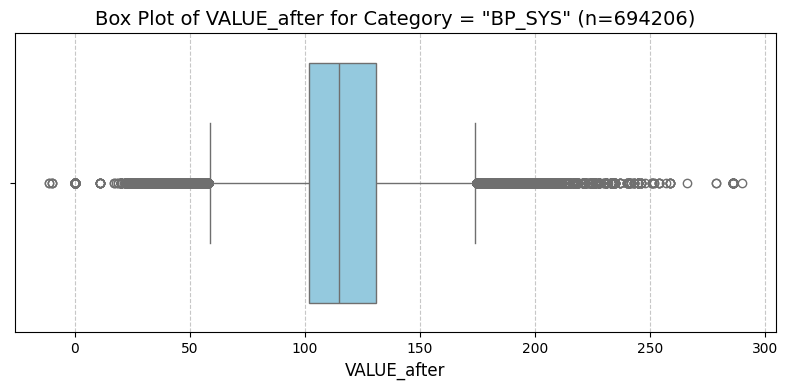

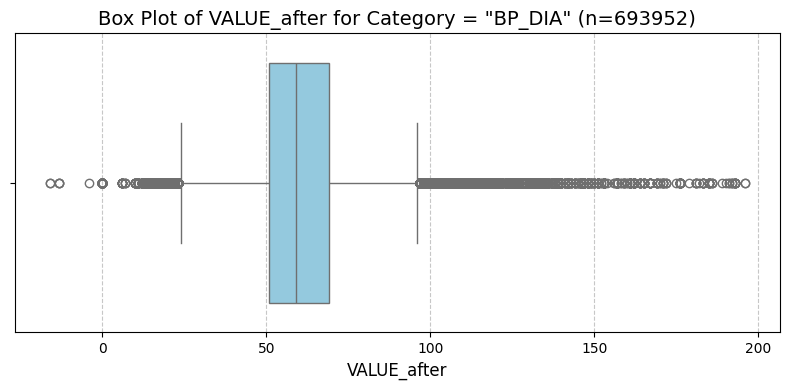

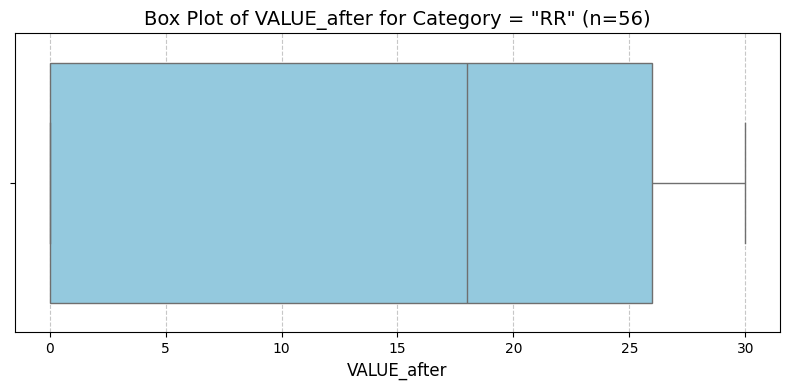

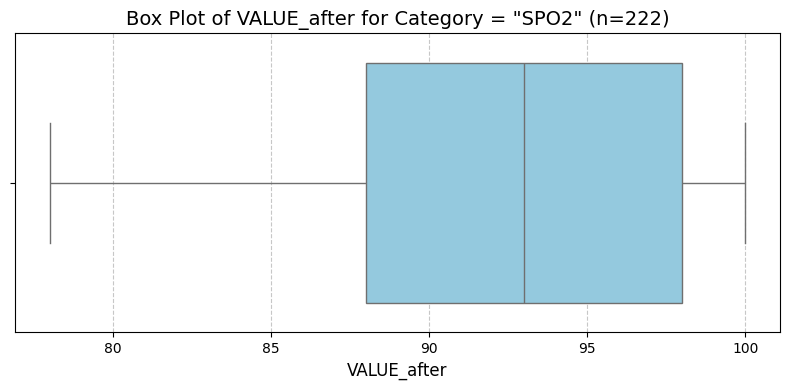

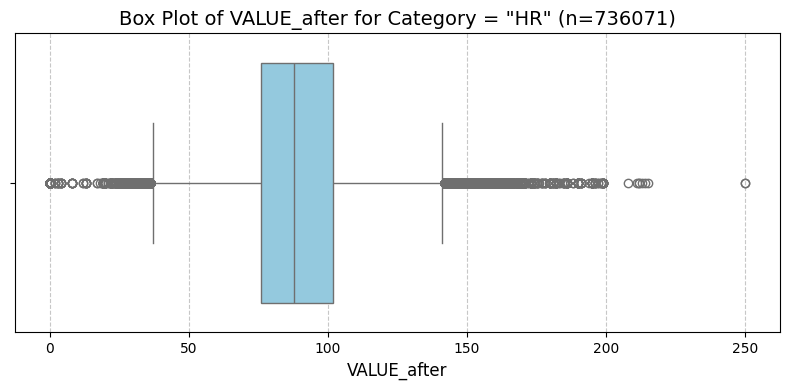

In [29]:
# Plot each vital Category after transfusion 

# Ensure VALUE_after is numeric
filtered_results['VALUE_after'] = pd.to_numeric(filtered_results['VALUE_after'], errors='coerce')

# Get the unique categories
categories = filtered_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = filtered_results[filtered_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

